# Imports and setup

In [1]:
import copy

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import gala.coordinates as gc

import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

%matplotlib inline
numpyro.enable_x64()
numpyro.set_host_device_count(2)

In [2]:
data = at.Table.read('../data/tmp/run_data.fits')
masks = at.Table.read('../data/tmp/run_data_masks.fits')
len(data)

28507

In [3]:
run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
len(bkg_data['phi1'])

23859

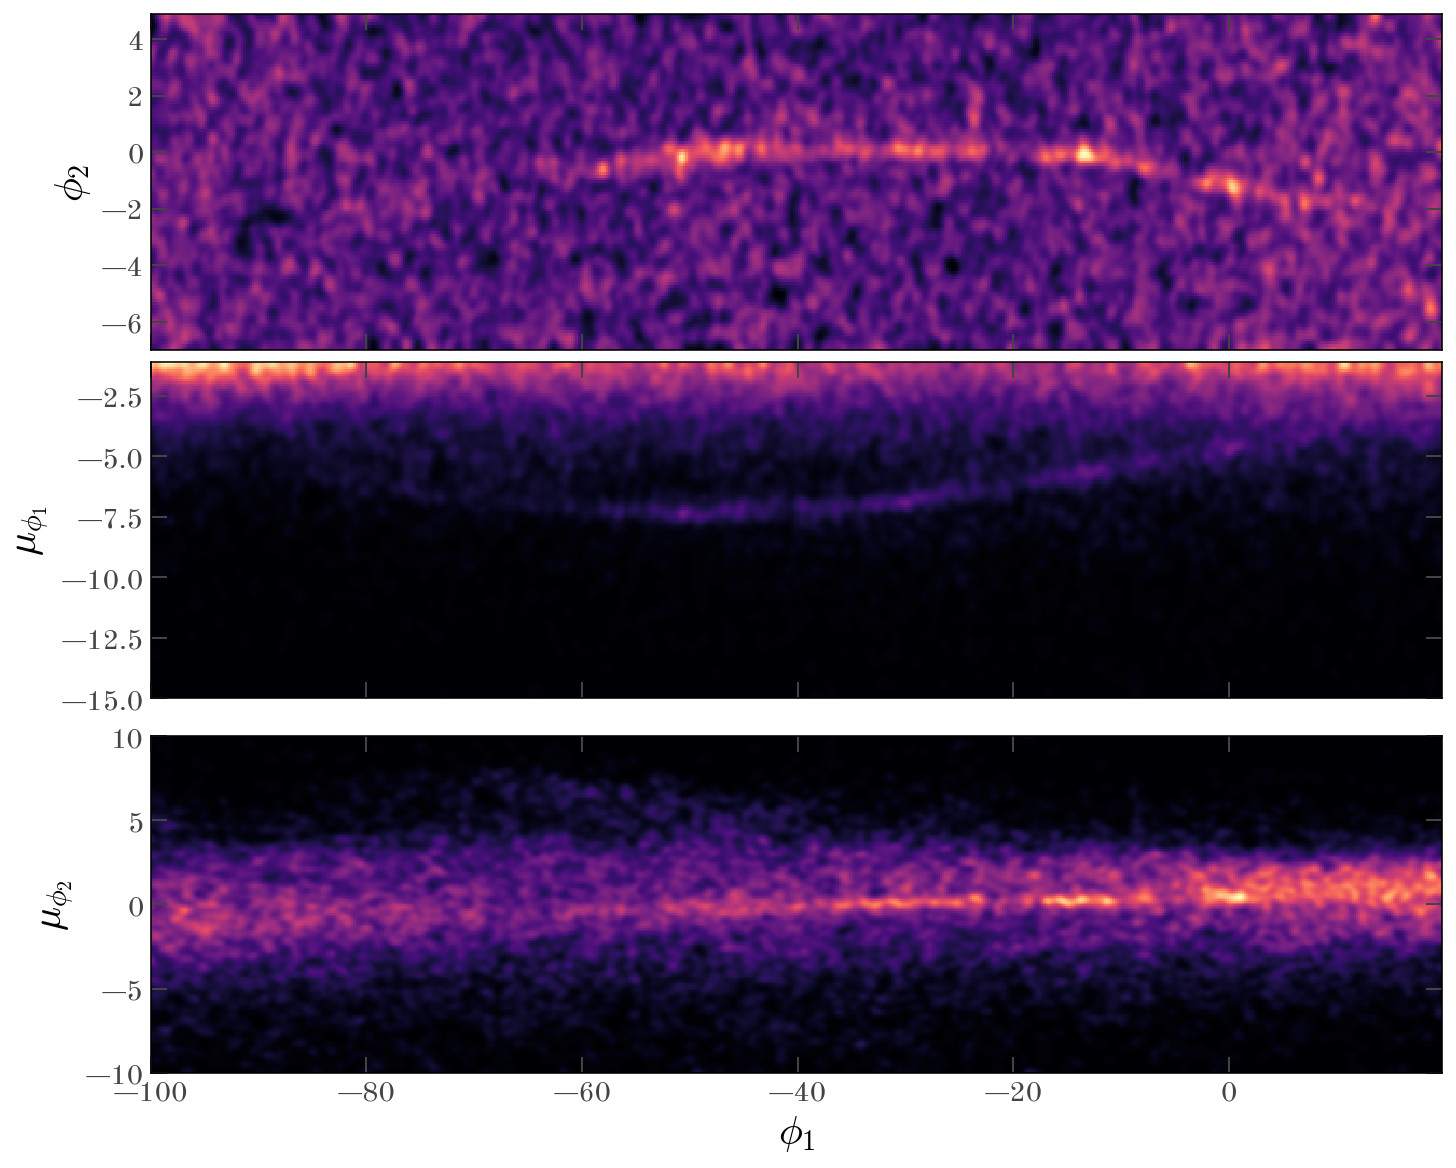

In [4]:
plot_data_projections(data=run_data, grids=GD1Base.default_grids, smooth=2);

# Background

In [5]:
# TODO: do initialization of background parameters using Galstreams stuff

In [6]:
bkg_init_p = {
    "ln_N": np.log(len(run_data['phi1'])),
    "phi1": {"zs": np.zeros(GD1BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, 1.),
        "ln_std1": np.ones_like(GD1BackgroundModel.pm1_knots),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 5.),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 2.)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, 0.),
        "ln_std1": np.ones_like(GD1BackgroundModel.pm2_knots),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, 0.),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 2.)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

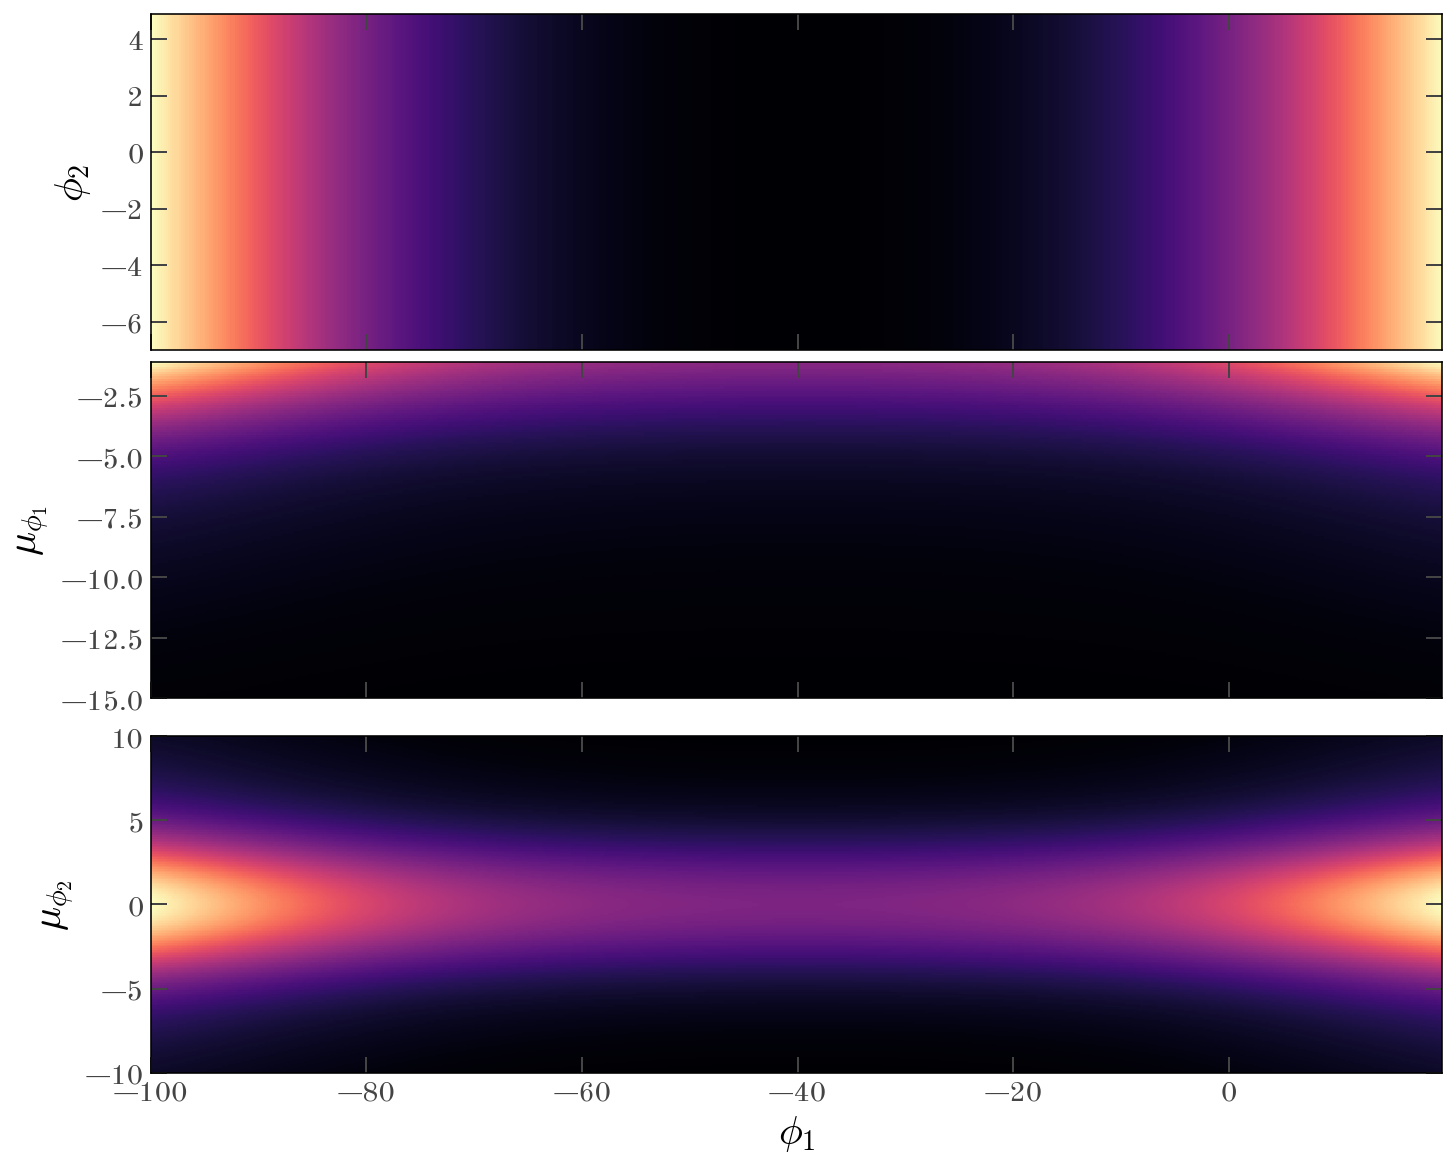

In [7]:
_ = background_init.plot_model_projections()

In [8]:
jax.jit(GD1BackgroundModel._objective)(bkg_init_p, bkg_data)

Array(2.70572353, dtype=float64)

In [9]:
bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

LbfgsbState(iter_num=Array(40, dtype=int64, weak_type=True), value=Array(2.38853805, dtype=float64), grad={'ln_N': Array(-0.00066349, dtype=float64), 'phi1': {'zs': Array([-7.85919242e-04, -4.81298229e-04, -2.82154943e-04, -3.93743973e-04,
        1.65934596e-04,  4.30903613e-04,  1.20551026e-04, -3.48593897e-05],      dtype=float64)}, 'phi2': {}, 'pm1': {'ln_std1': Array([ 1.09508004e-04,  2.28792637e-04, -1.09599918e-04, -1.43021899e-04,
        3.42359871e-05,  1.57463148e-04,  3.65941477e-04,  1.51890433e-04,
       -1.05851035e-04, -7.16370924e-05, -1.51696587e-04,  7.04845469e-05,
       -1.20233355e-04], dtype=float64), 'ln_std2': Array([ 7.77762433e-06, -1.31681776e-04,  2.19689249e-04, -1.75549789e-04,
       -1.39400312e-04,  7.48137605e-05,  2.42358892e-04,  1.27258746e-04,
       -1.25281754e-04,  4.23185666e-05,  3.26144029e-05, -1.06938738e-04,
       -7.87331159e-05], dtype=float64), 'mean1': Array([-3.86515248e-05, -6.66243082e-05,  1.58337240e-05, -9.12650270e-06,
    

In [10]:
bkg_opt_pars

{'ln_N': Array(10.07925307, dtype=float64),
 'phi1': {'zs': Array([-0.28391197, -0.6073251 , -0.64827206,  0.14366067,  0.53096201,
          0.35999122,  0.58825019,  0.35737847], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([0.49611526, 0.59291528, 0.46233738, 0.44192344, 0.83890392,
         0.68411943, 0.67255408, 0.52764826, 0.51981023, 0.66254718,
         0.52009107, 0.72979973, 0.81661487], dtype=float64),
  'ln_std2': Array([1.58051158, 1.43355738, 1.53086003, 1.54355834, 1.66295014,
         1.66662192, 1.77695225, 1.77378335, 1.68470091, 1.70580238,
         1.62229651, 1.61573165, 1.7226983 ], dtype=float64),
  'mean1': Array([1.12185106, 1.1669884 , 1.12798086, 1.19706331, 1.08193554,
         1.04258188, 1.02451592, 1.08868427, 1.11408721, 1.12770889,
         1.13015096, 1.11147607, 1.00900623], dtype=float64),
  'mean2': Array([5.01737558, 5.02349365, 5.02644911, 5.01495411, 5.00913382,
         5.01526537, 5.00083559, 4.99833724, 4.99976424, 5.01620391,
    

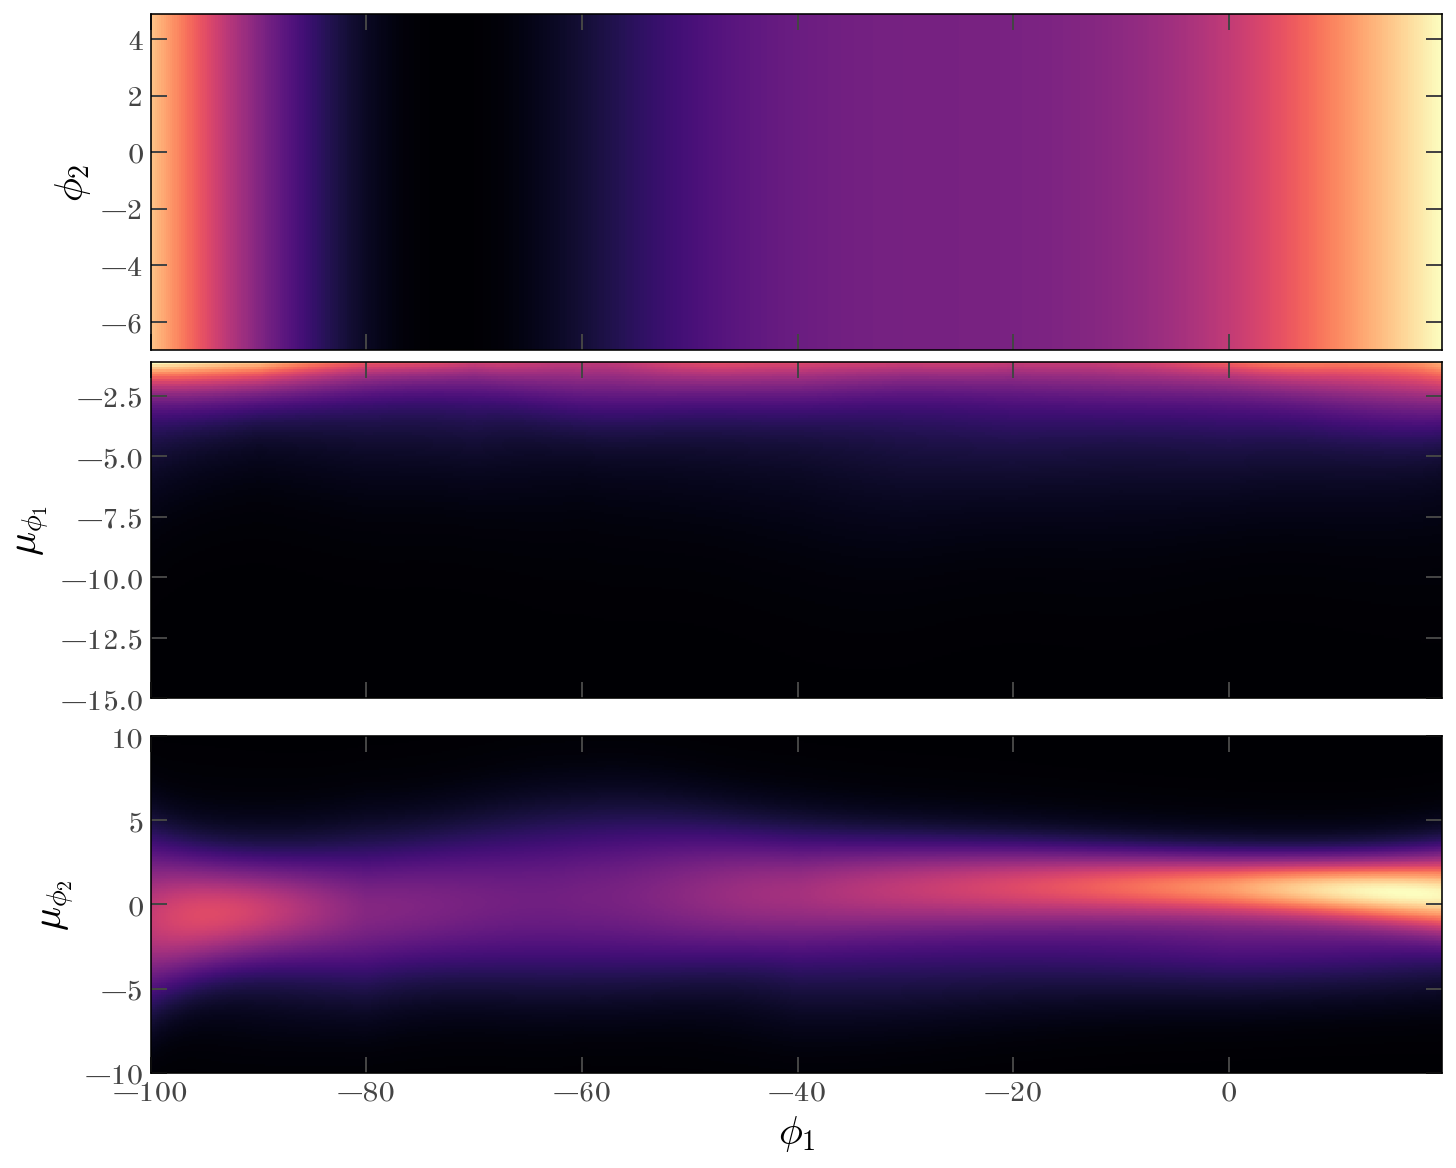

In [11]:
_ = background_opt.plot_model_projections()

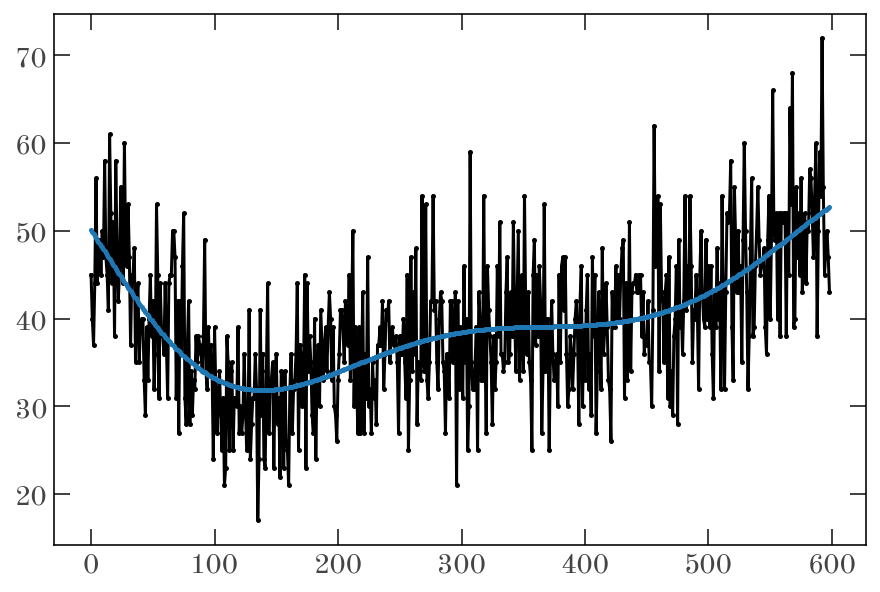

In [12]:
H_data, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)
grids, ln_ns = background_opt.evaluate_on_2d_grids()

plt.figure(figsize=(6, 4))
plt.plot(H_data.T.sum(axis=0))
plt.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0))

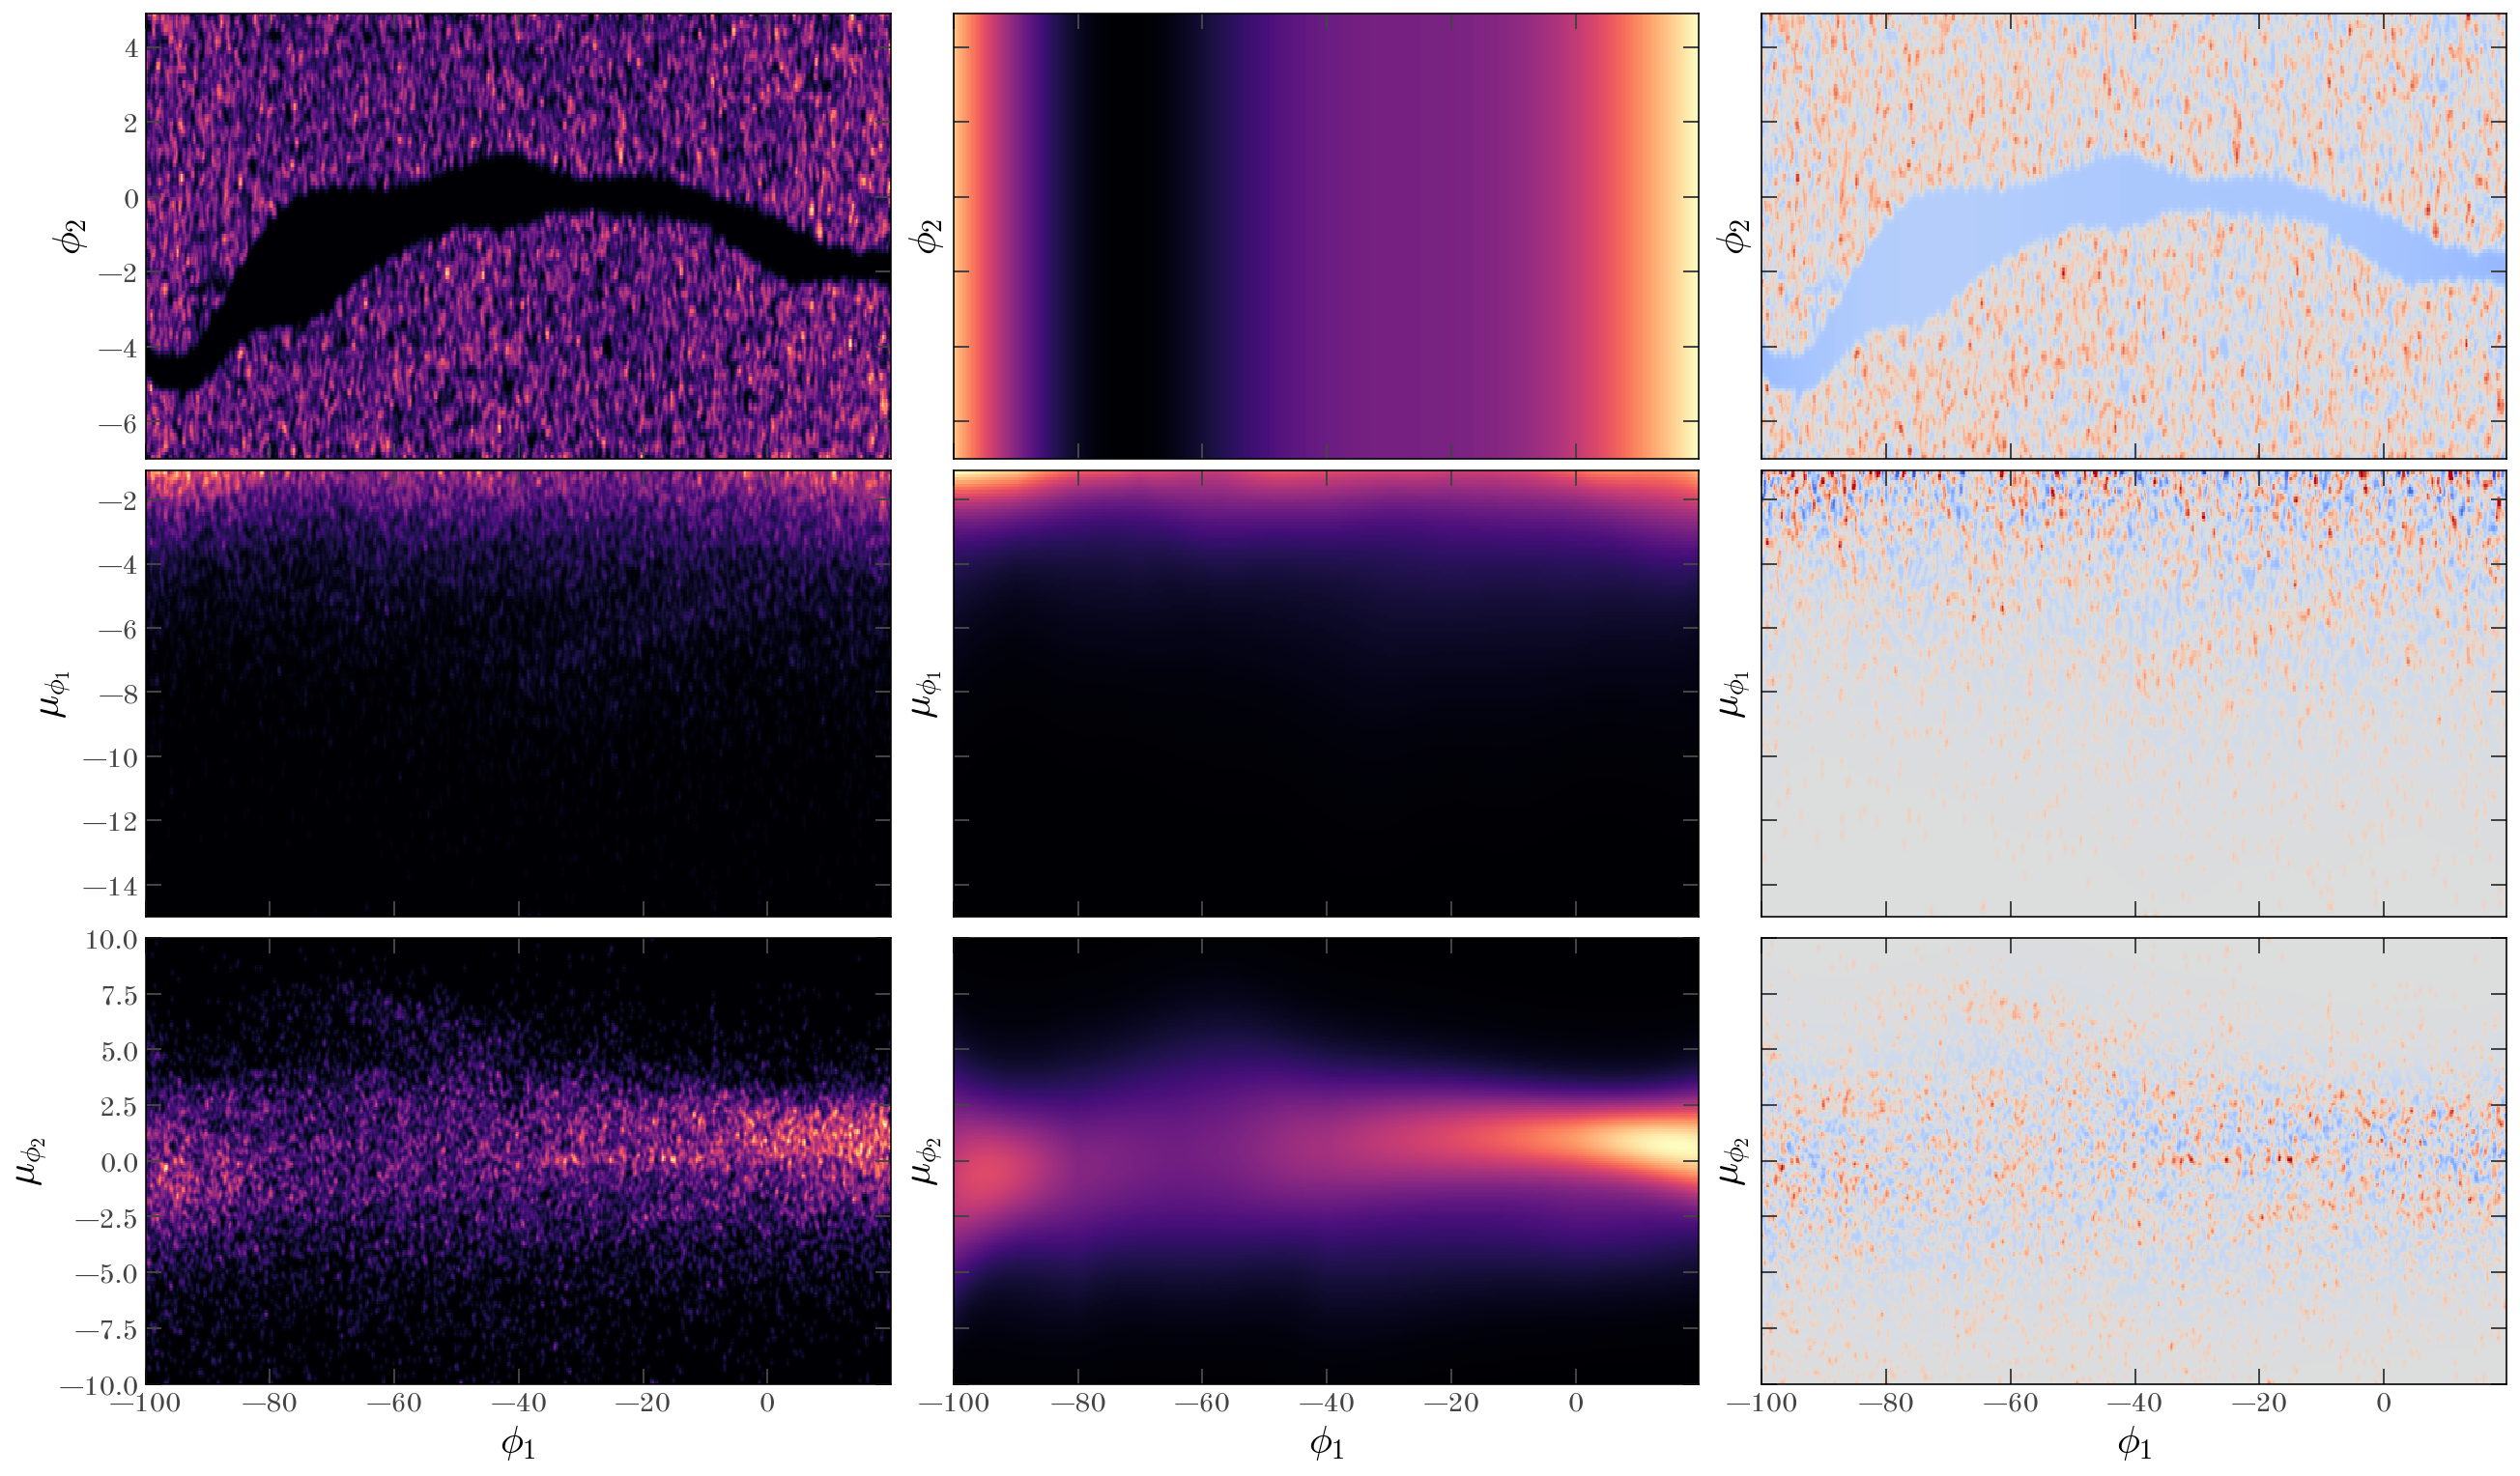

In [13]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Stream

In [14]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data = {k: v[stream_mask] for k, v in run_data.items()}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-100, 20, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [15]:
import numpyro.distributions as dist
stick = dist.transforms.StickBreakingTransform()

xs = GD1StreamModel.phi1_locs.squeeze()
ws = np.ones_like(xs)

pt1 = (-104, 0)
pt2 = (-70, 1.)
_mask = xs <= pt2[0]
ws[_mask] = (pt2[1]-pt1[1]) / (pt2[0] - pt1[0]) * (xs[_mask] - pt1[0]) + pt1[1]

pt1 = (0, 1.)
pt2 = (24, 0.)
_mask = xs >= pt1[0]
ws[_mask] = (pt2[1]-pt1[1]) / (pt2[0] - pt1[0]) * (xs[_mask] - pt1[0]) + pt1[1]
ws /= ws.sum()

zs = stick.inv(ws)
zs = np.clip(zs, -8, 8.)

In [16]:
stream_init_p = {
    "ln_N": np.log(stream_mask.sum()),
    "phi1": {
        # "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
        "zs": zs
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -2)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -2)
    }
}

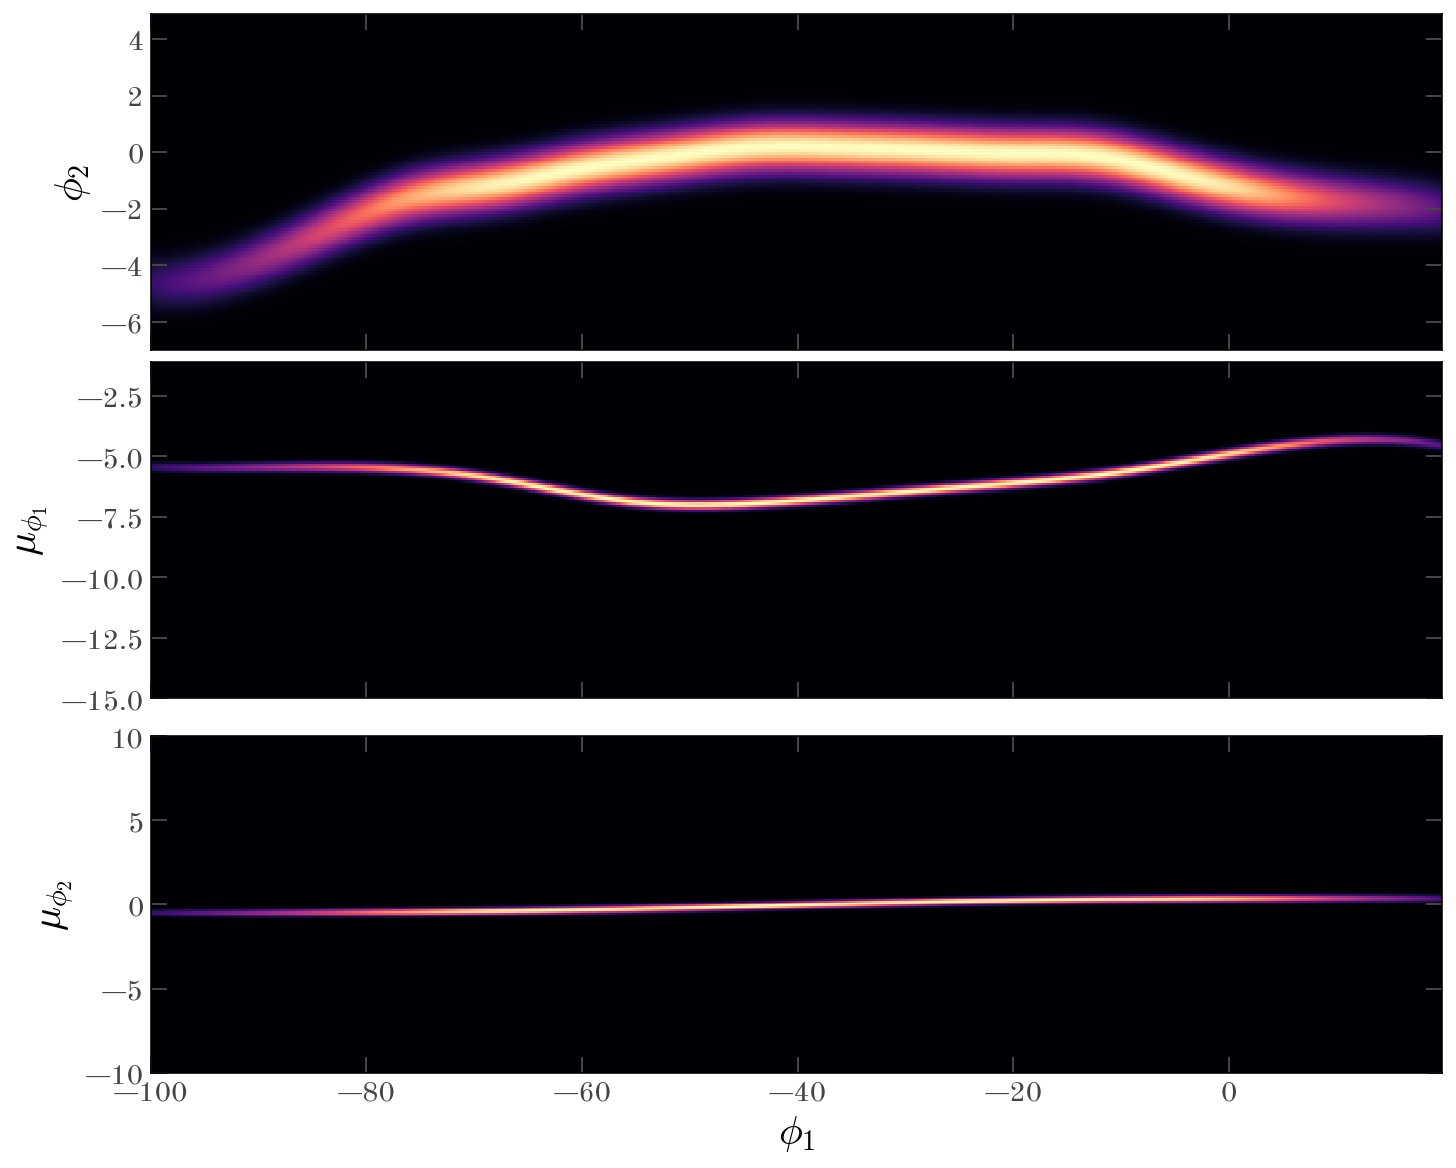

In [17]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [18]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

LbfgsbState(iter_num=Array(1024, dtype=int64, weak_type=True), value=Array(1.64099416, dtype=float64), grad={'ln_N': Array(-8.89730985e-17, dtype=float64), 'phi1': {'zs': Array([-3.48258334e-07, -2.07535135e-06,  7.95811125e-07, -2.15855441e-07,
        3.16543636e-07,  8.72873440e-07, -5.68315814e-07,  6.76837003e-07,
       -2.66279140e-06,  3.32865159e-07,  9.38441316e-07,  3.45090620e-06,
        1.17078490e-06,  5.20687624e-07,  1.25419681e-06,  1.01101632e-06,
       -2.49902854e-06,  4.29866686e-07,  3.99469729e-07, -1.41272869e-06,
       -6.74181129e-07,  9.39704890e-07, -1.07302762e-06, -4.26120262e-06,
        4.04866787e-07,  3.73045204e-07, -7.83958673e-07,  1.08370021e-06,
       -7.87662653e-07,  7.64458134e-07,  7.62283044e-07,  2.36734169e-07],      dtype=float64)}, 'phi2': {'ln_std': Array([ 5.12980417e-06, -1.47296704e-06, -3.35296146e-06,  2.65072968e-06,
       -2.12572745e-06,  2.34668649e-06,  7.01894466e-07,  8.20913291e-07,
        2.99222619e-07, -2.79866651e-

Text(0, 0.5, '$\\phi_2$')

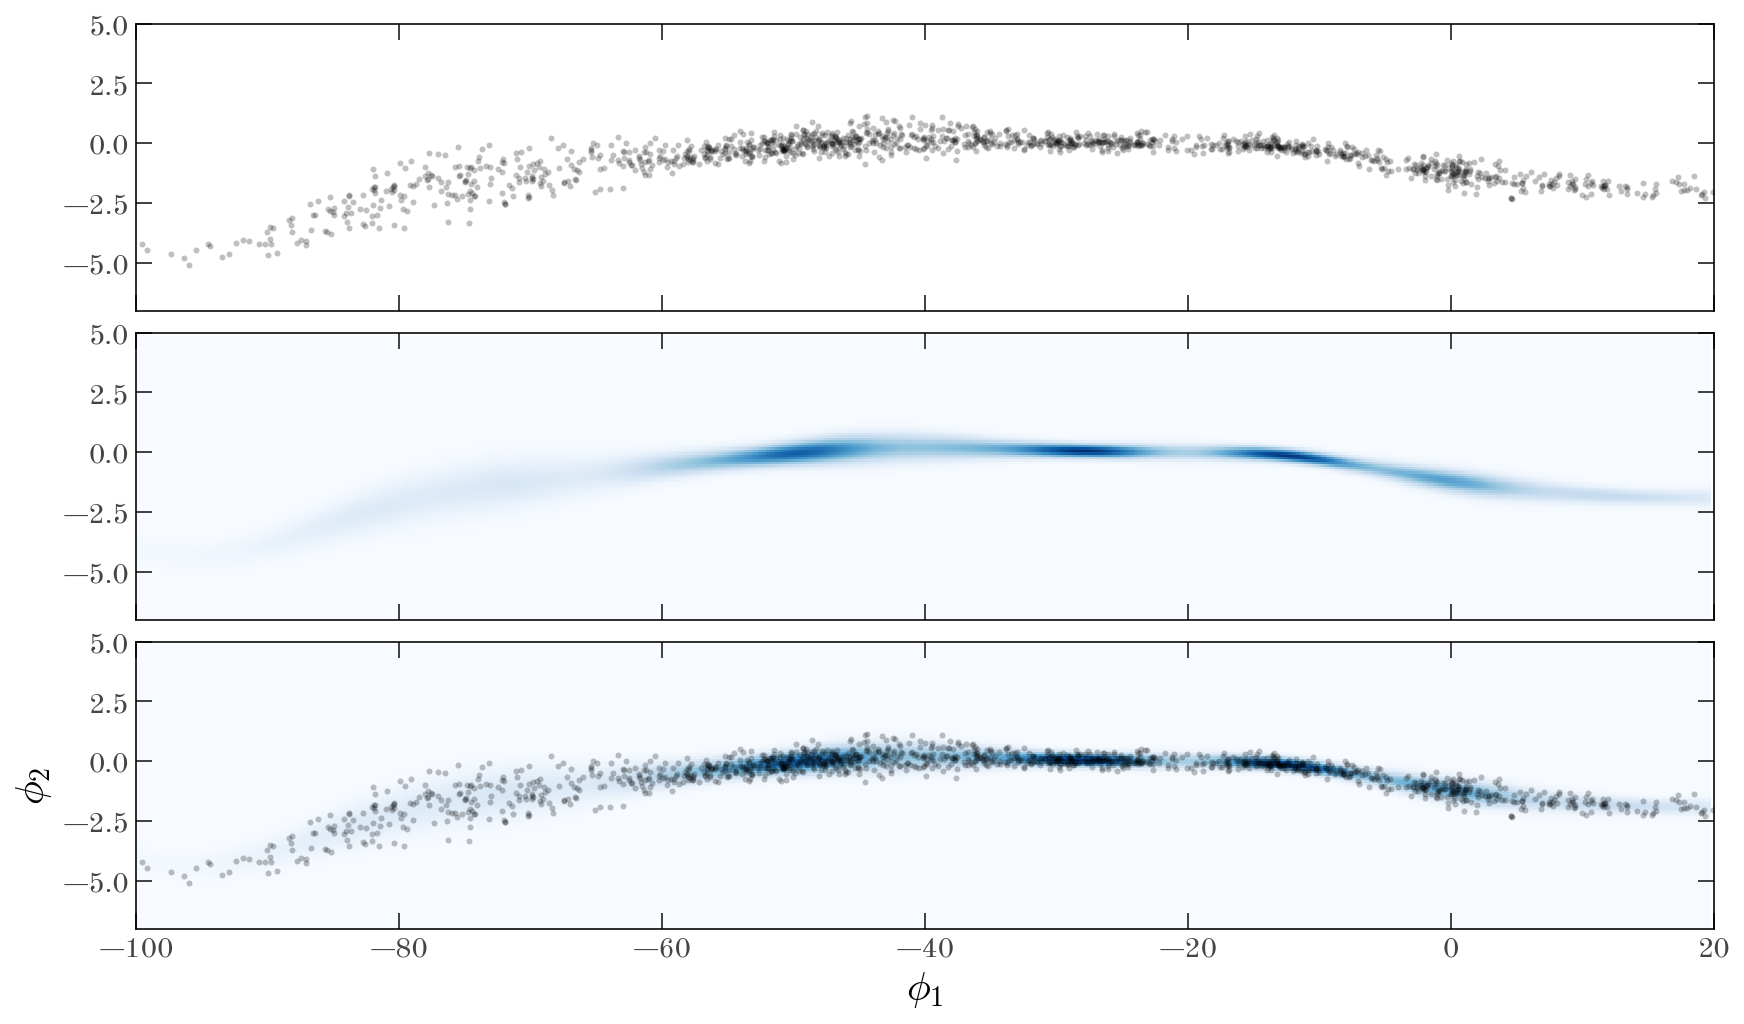

In [19]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )

for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

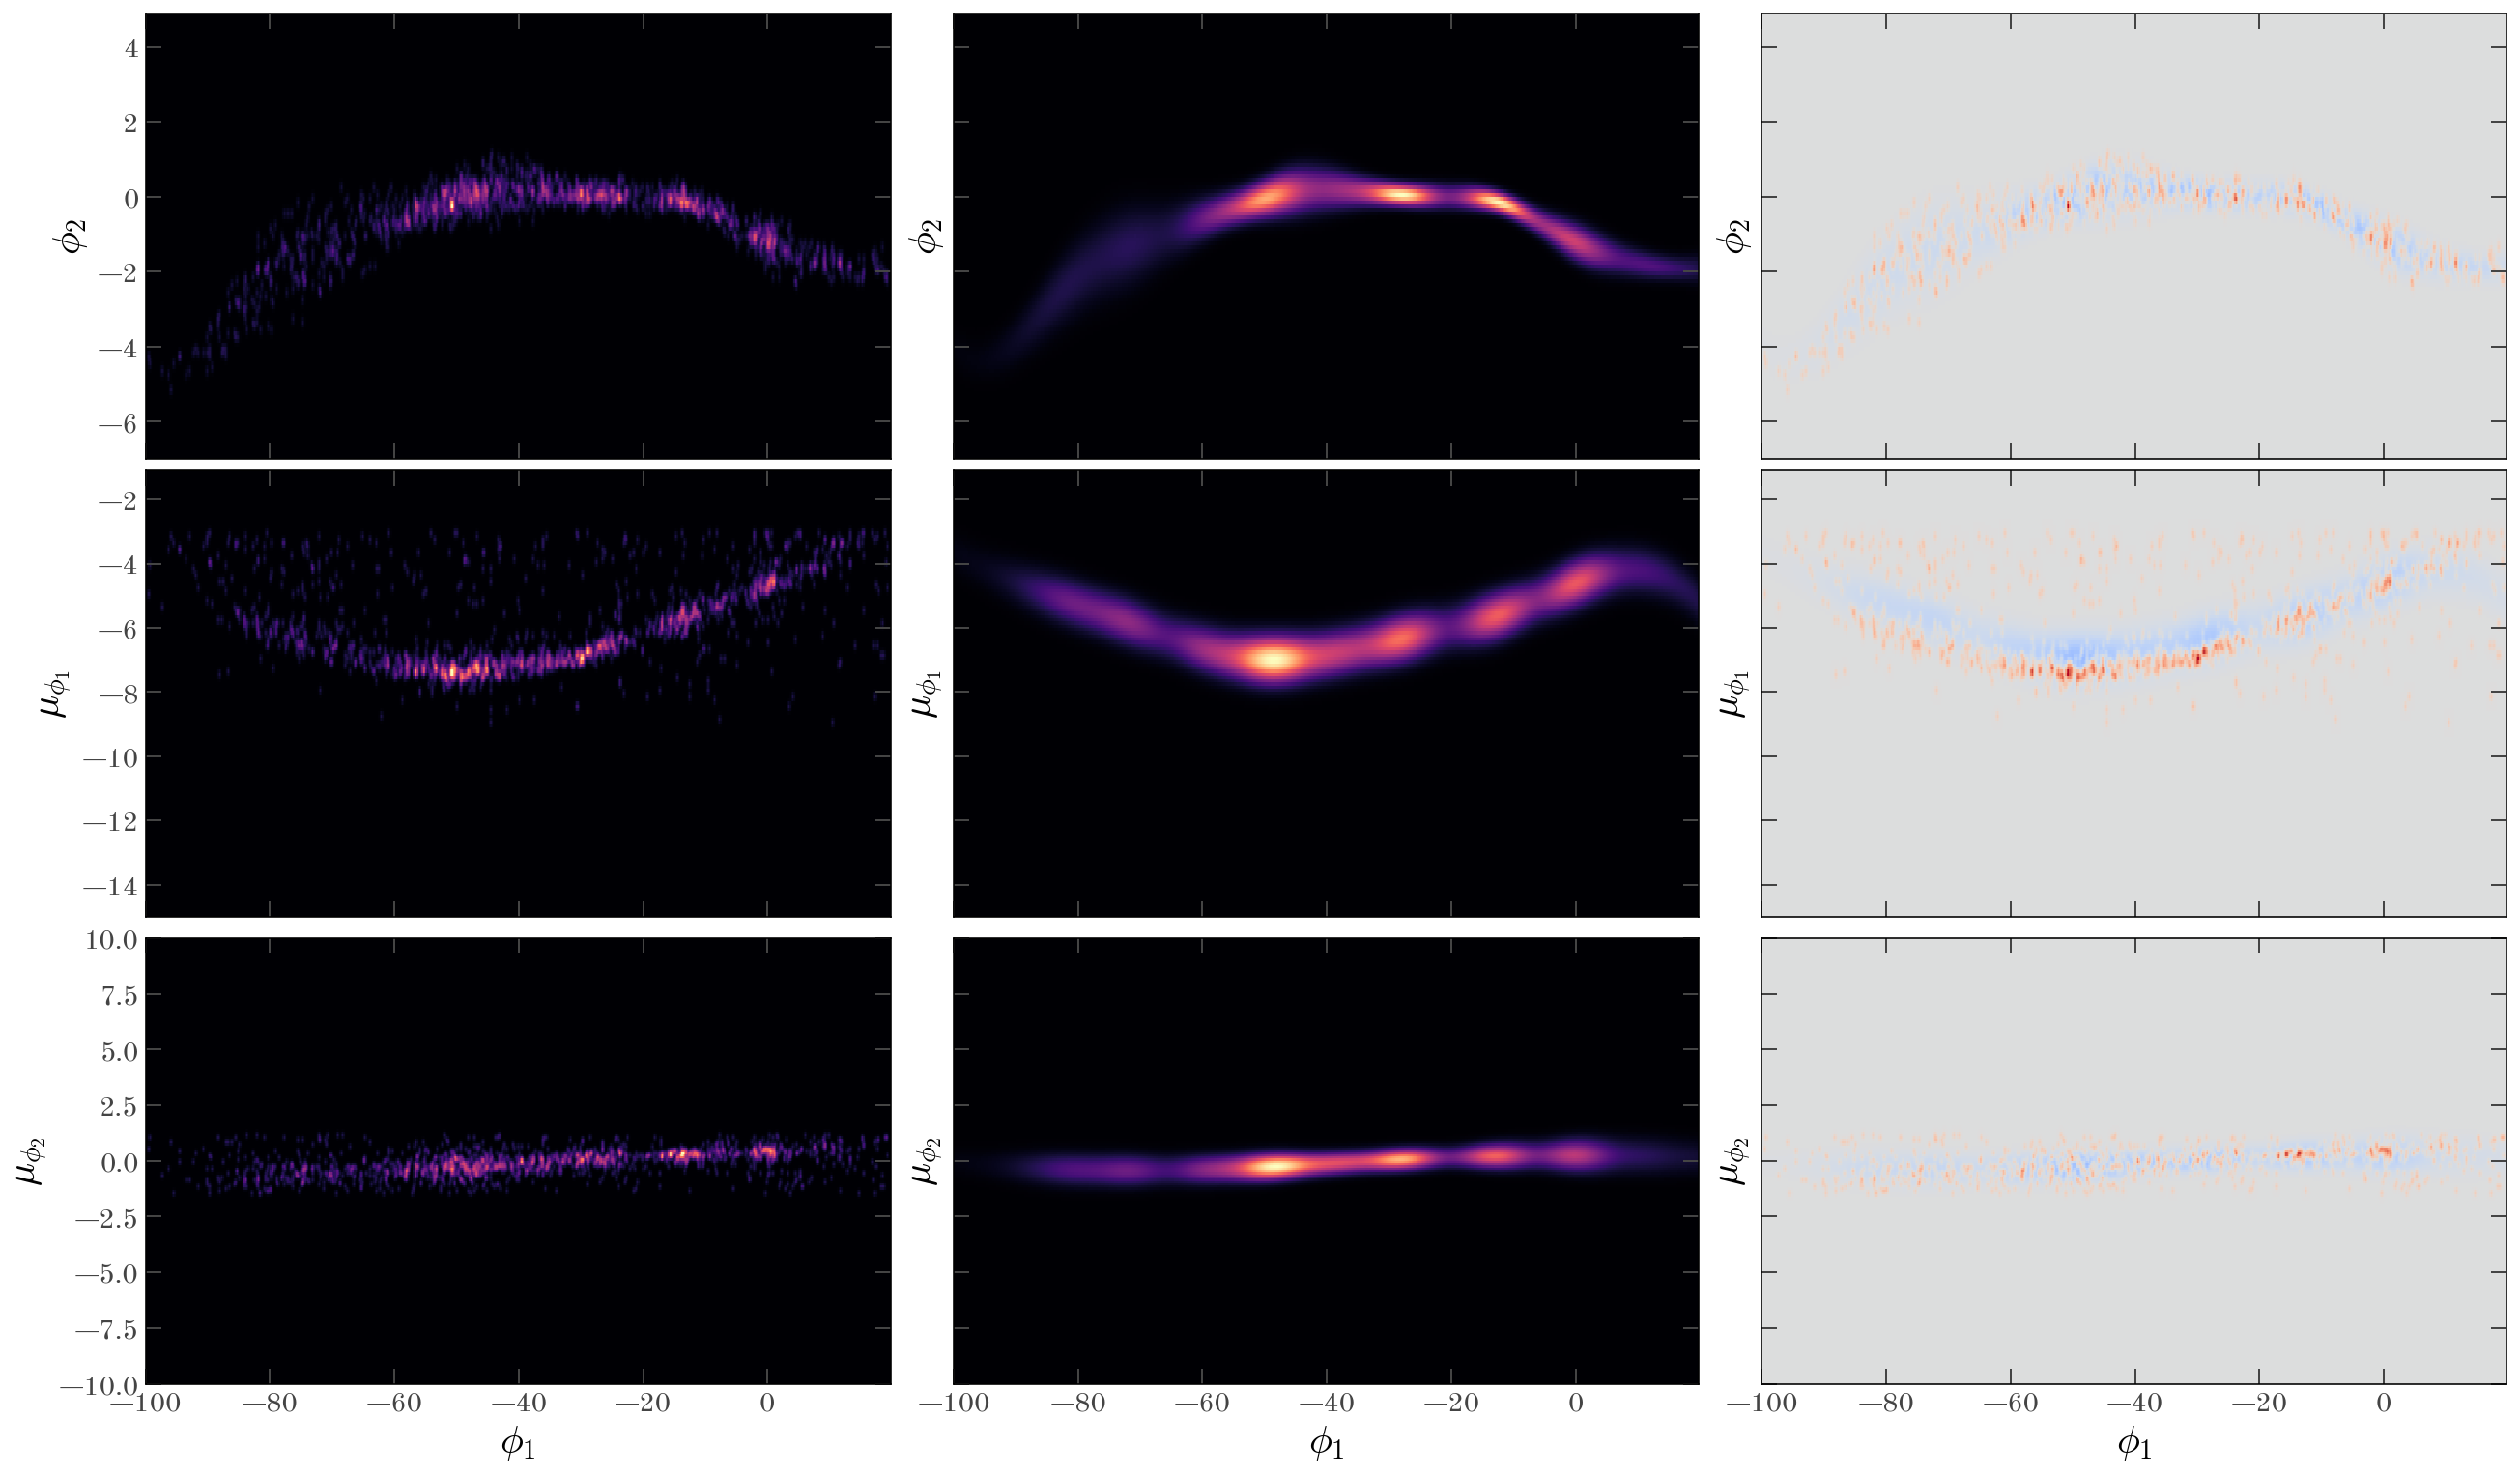

In [20]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [21]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [22]:
mix_init = StreamMixtureModel(mix_params0, Components)

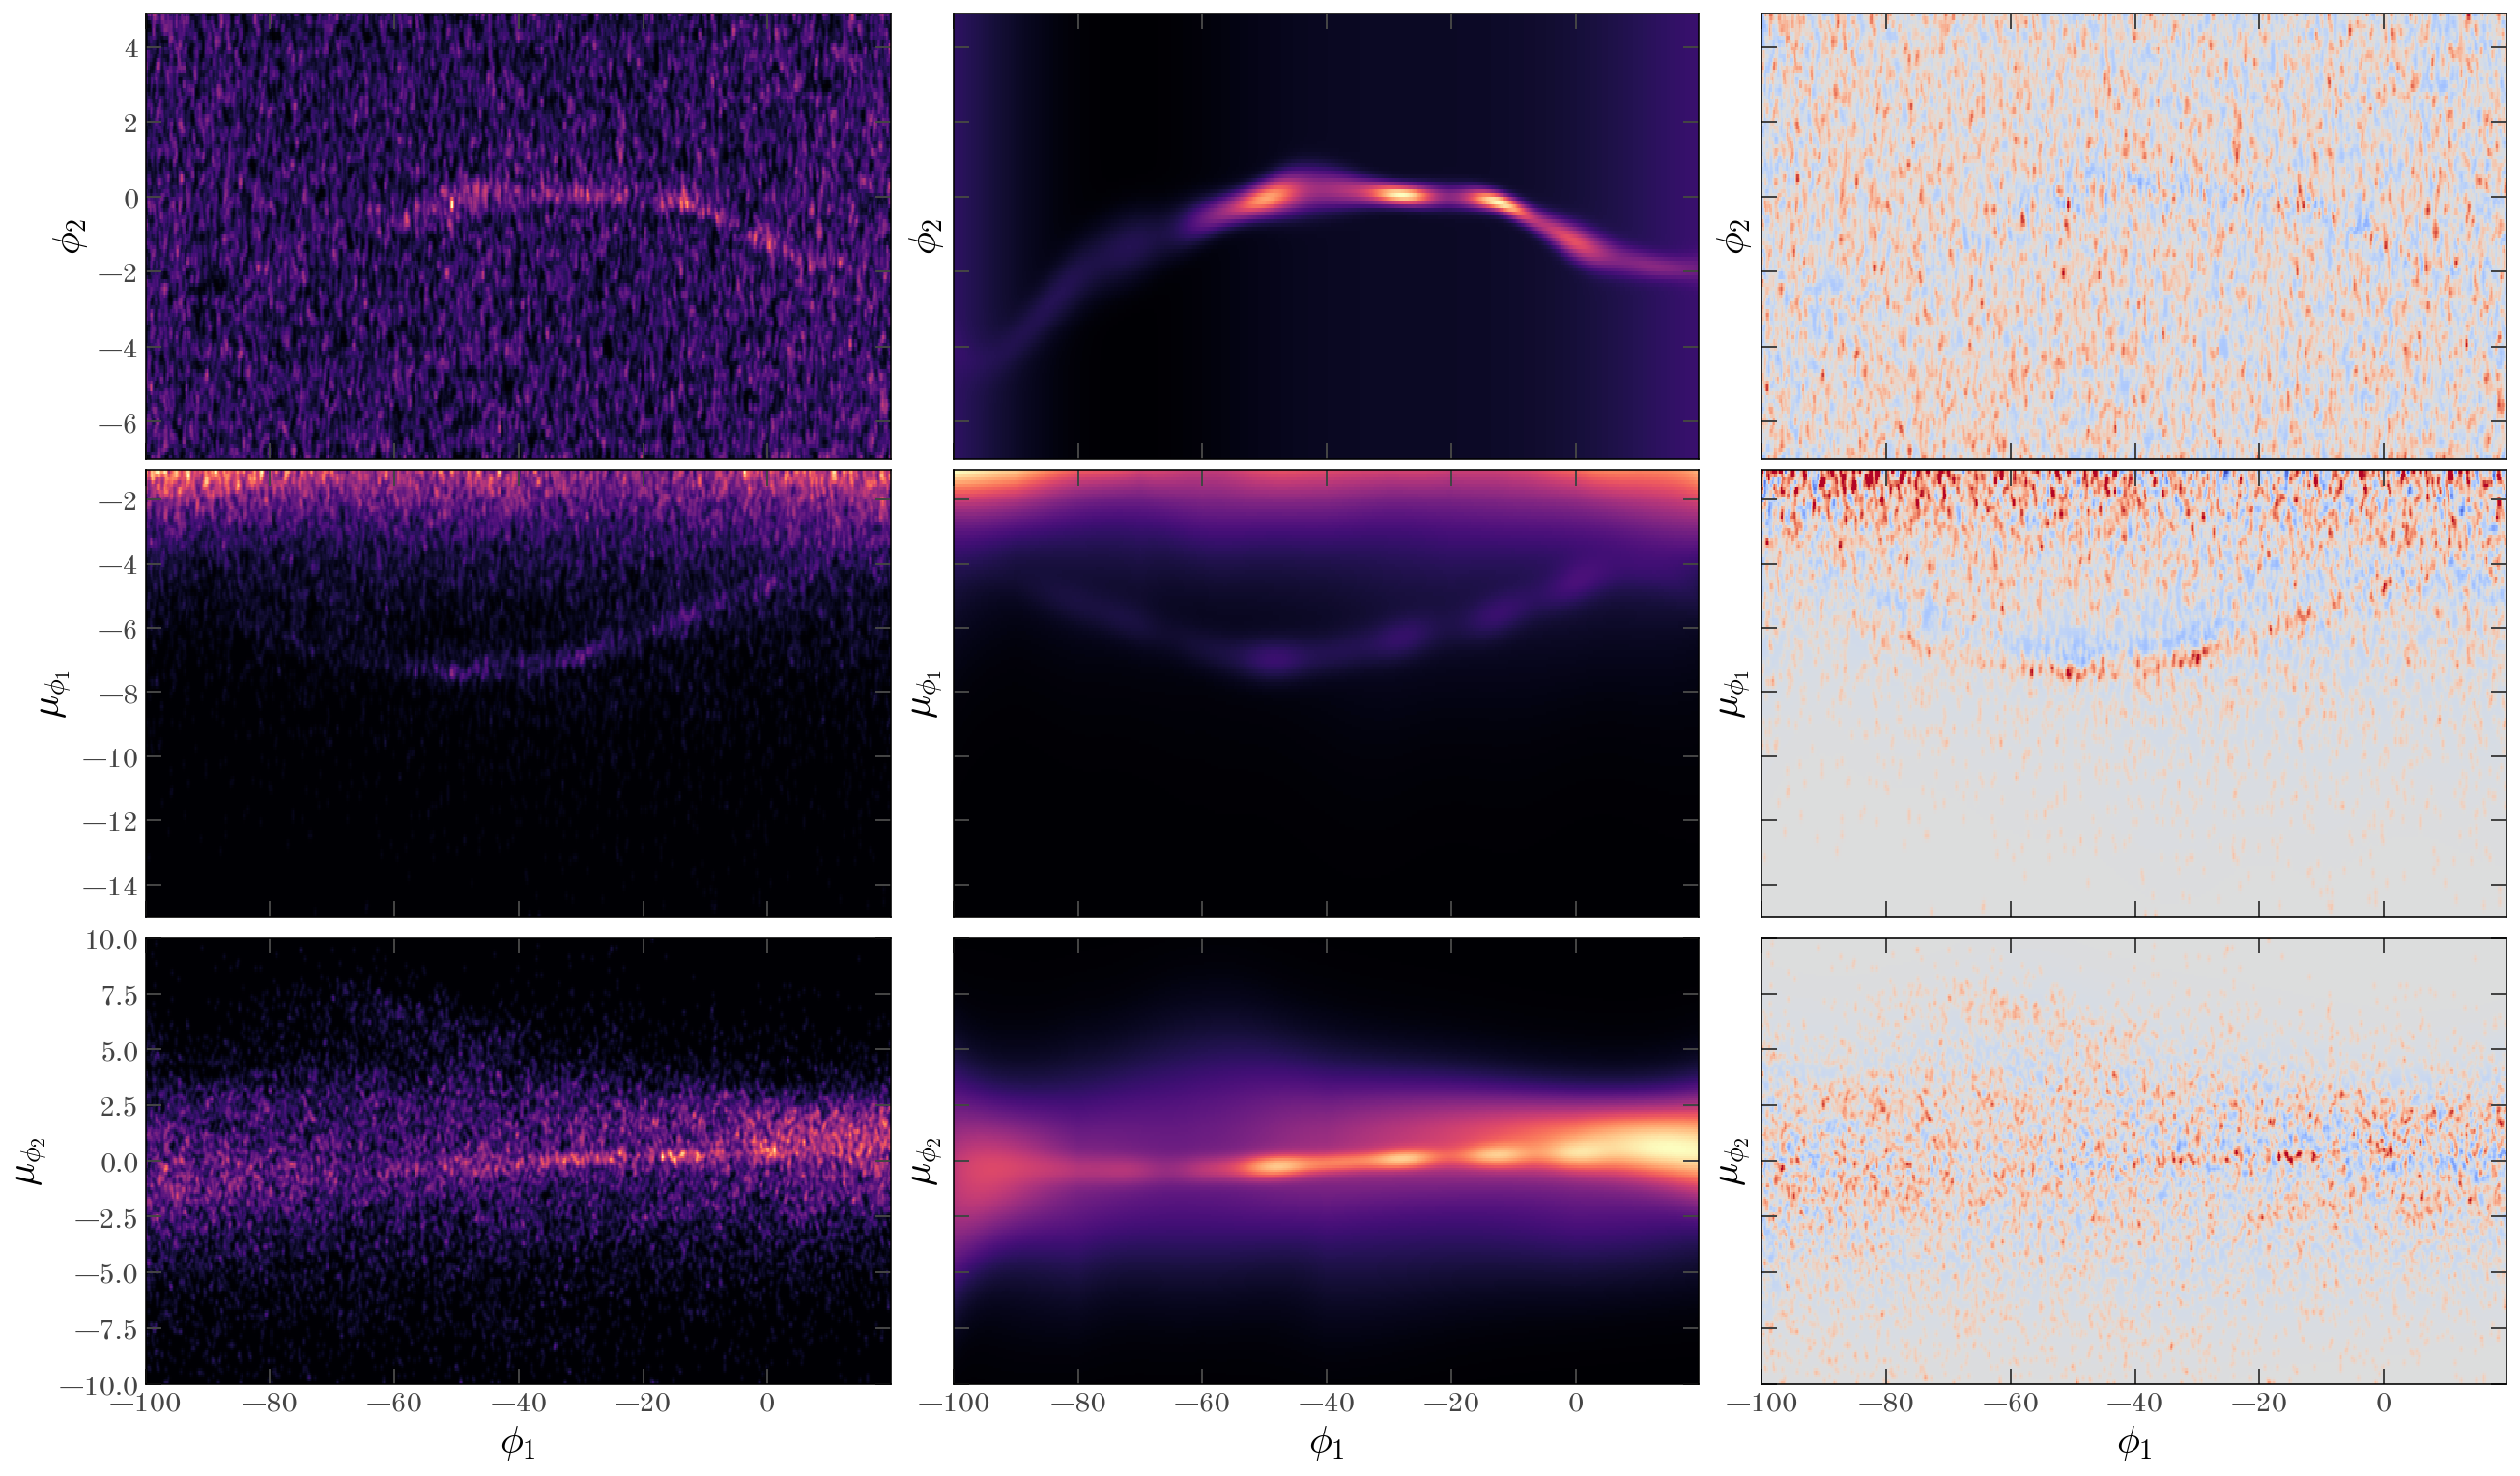

In [23]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [24]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(2.11153675, dtype=float64, weak_type=True), success=True, status=0, iter_num=1184, hess_inv=LbfgsInvHessProduct(sk=[[-5.45835556e-05  2.67273591e-04 -4.49660320e-04 ... -6.01528811e-05
  -2.33552020e-05  9.08352596e-05]
 [ 1.66449659e-04  5.32286126e-04 -5.69014328e-04 ...  2.19814193e-04
   6.53879786e-05  1.56673419e-04]
 [-8.39989058e-05  4.19152632e-05  2.30280856e-04 ... -1.58256010e-04
  -4.71564178e-05 -1.33314597e-04]
 ...
 [-9.01758256e-05  7.33942683e-06 -1.85428056e-04 ... -4.33048736e-05
  -1.82813592e-05  1.41820833e-04]
 [-3.63382841e-05  1.24641646e-06 -3.52367065e-04 ...  1.15485690e-05
   1.37178055e-08  1.17605815e-04]
 [-1.23116574e-05  7.88041681e-05 -3.72288670e-04 ...  2.75330969e-05
   5.91511916e-06  9.24103588e-05]], yk=[[-5.30230654e-05  2.30114352e-06  8.42972633e-07 ... -1.77035144e-05
  -5.80769135e-06  3.82118924e-07]
 [ 1.59467942e-04  5.58962893e-06  2.03185550e-06 ...  5.84711974e-05
   1.88648664e-05 -1.31105906e-06]
 [-

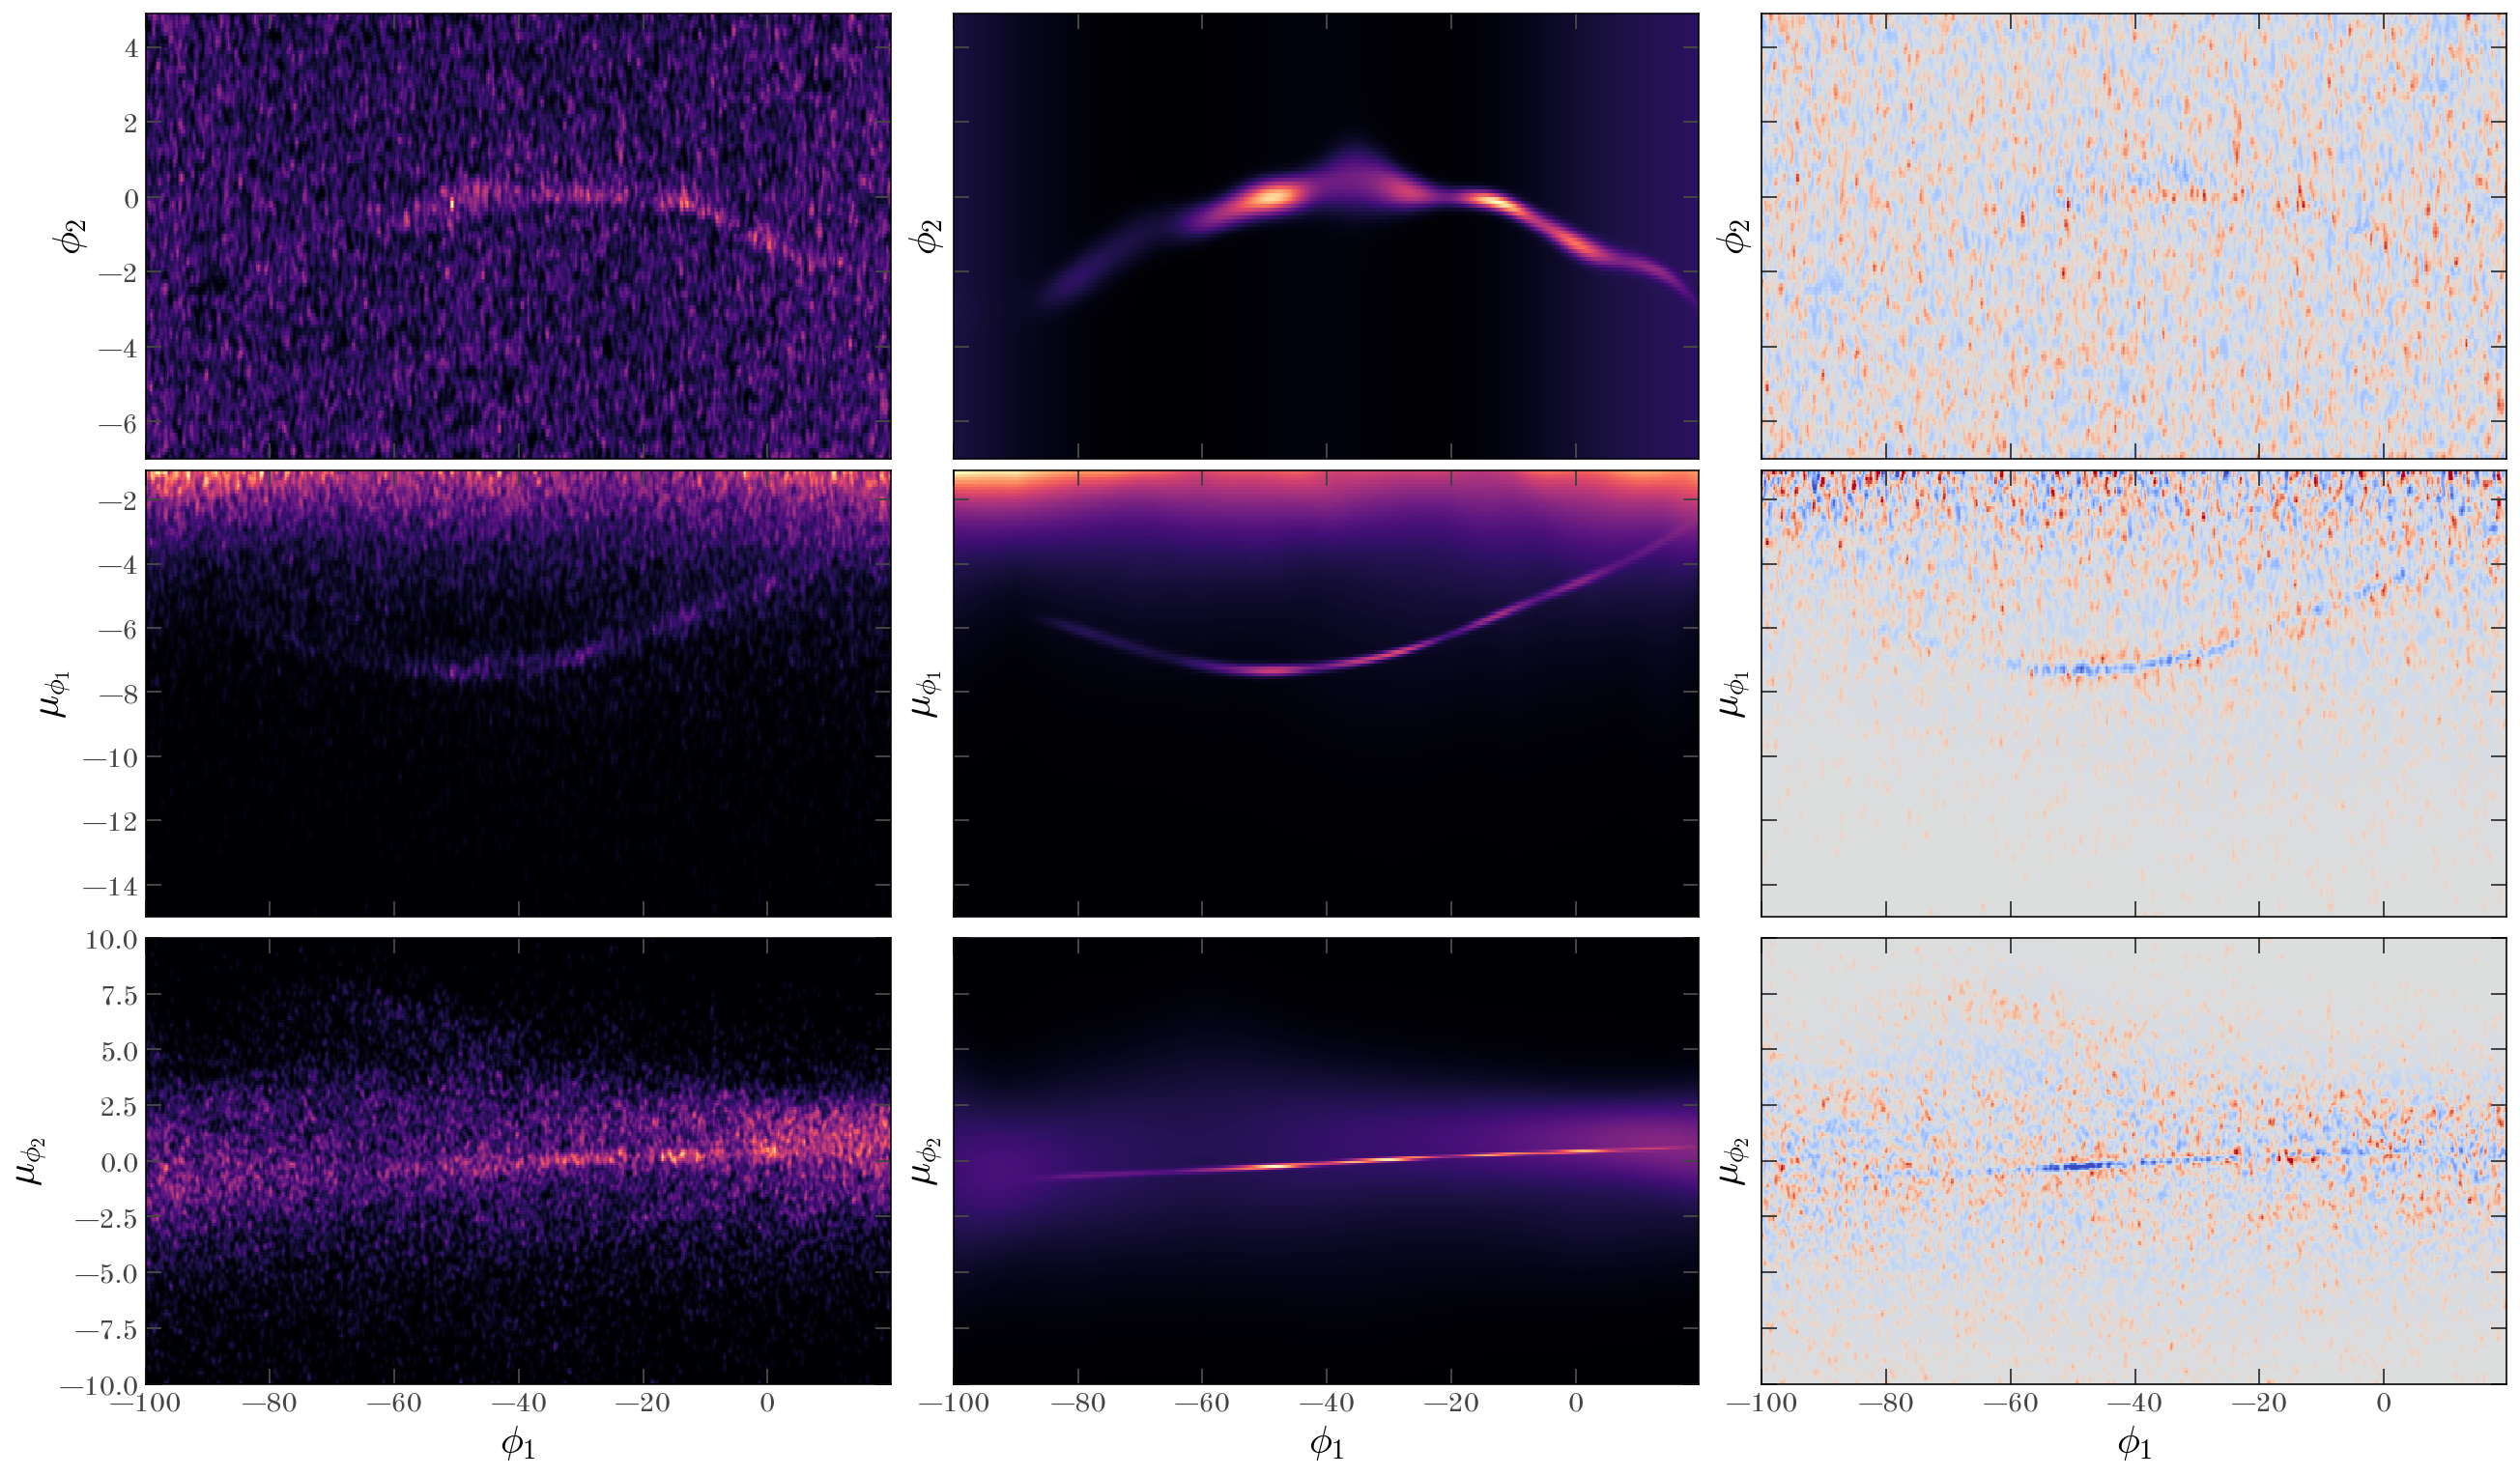

In [25]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [26]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

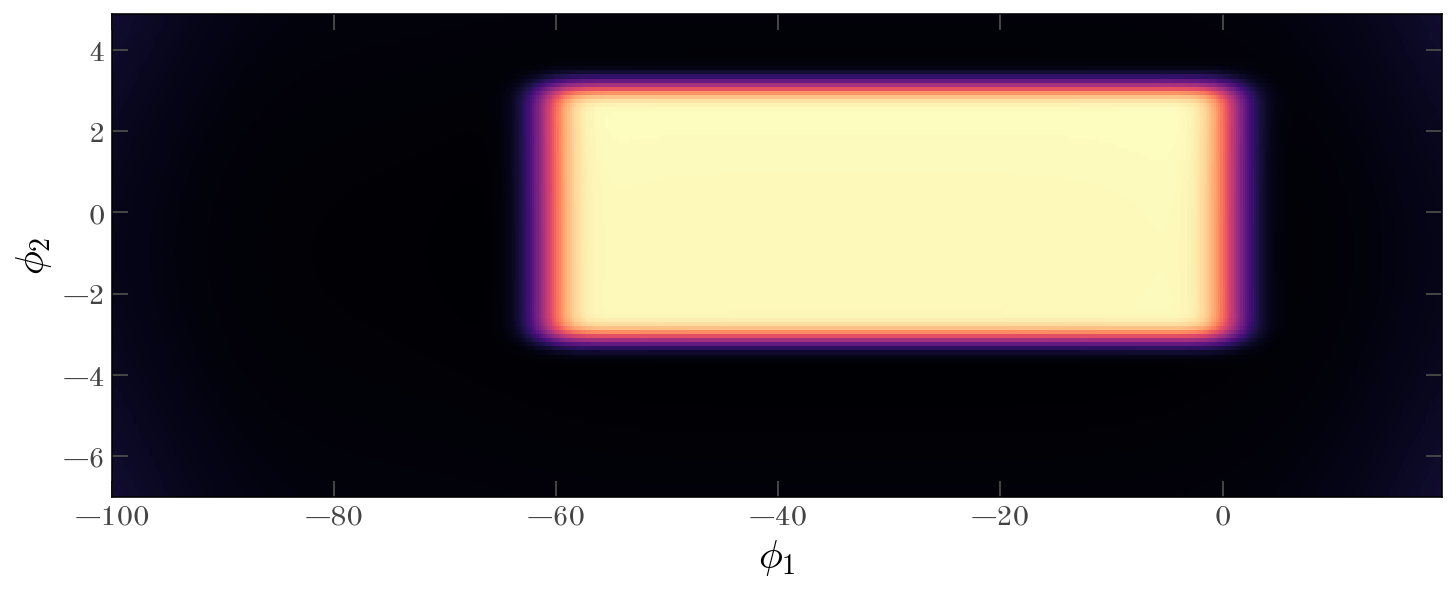

In [27]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [28]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": copy.deepcopy(stream_opt_pars),
    "background": copy.deepcopy(bkg_opt_pars),
    "offtrack": copy.deepcopy(offtrack_init_p),
}
full_mix_params0["offtrack"]["pm1"] = {}
full_mix_params0["offtrack"]["pm2"] = {}

In [29]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [30]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

ScipyMinimizeInfo(fun_val=Array(2.10444402, dtype=float64, weak_type=True), success=True, status=0, iter_num=5109, hess_inv=LbfgsInvHessProduct(sk=[[-1.63272565e-05 -1.00902180e-04 -3.88933312e-05 ...  6.81014011e-05
   2.71218011e-05  8.74386699e-05]
 [-4.23253662e-05 -1.43234517e-04 -7.66240273e-05 ...  6.53091400e-05
   2.43060928e-05  2.03570811e-04]
 [ 2.31900808e-04  1.46980532e-04  4.06893870e-06 ...  5.79493757e-05
   1.06472360e-05  3.10283863e-04]
 ...
 [-1.36261592e-04  4.81954475e-05 -1.39761193e-06 ... -1.05456956e-04
  -3.94191790e-05  1.34167334e-04]
 [-3.18508694e-05 -1.47081237e-04 -5.14121988e-05 ...  1.59131667e-04
   6.19519812e-05  3.78986443e-05]
 [-4.34826424e-05 -1.72307028e-04 -5.80774012e-05 ...  1.56249922e-04
   6.18925420e-05  8.62674969e-05]], yk=[[-1.57254097e-05 -9.50695120e-07 -1.75148382e-07 ...  2.10296823e-05
   7.61724698e-06 -3.48505161e-07]
 [-4.06963605e-05 -1.18337855e-06 -1.61202538e-07 ...  1.90952962e-05
   6.93154766e-06 -1.67243919e-07]
 [ 

(<Figure size 720x288 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

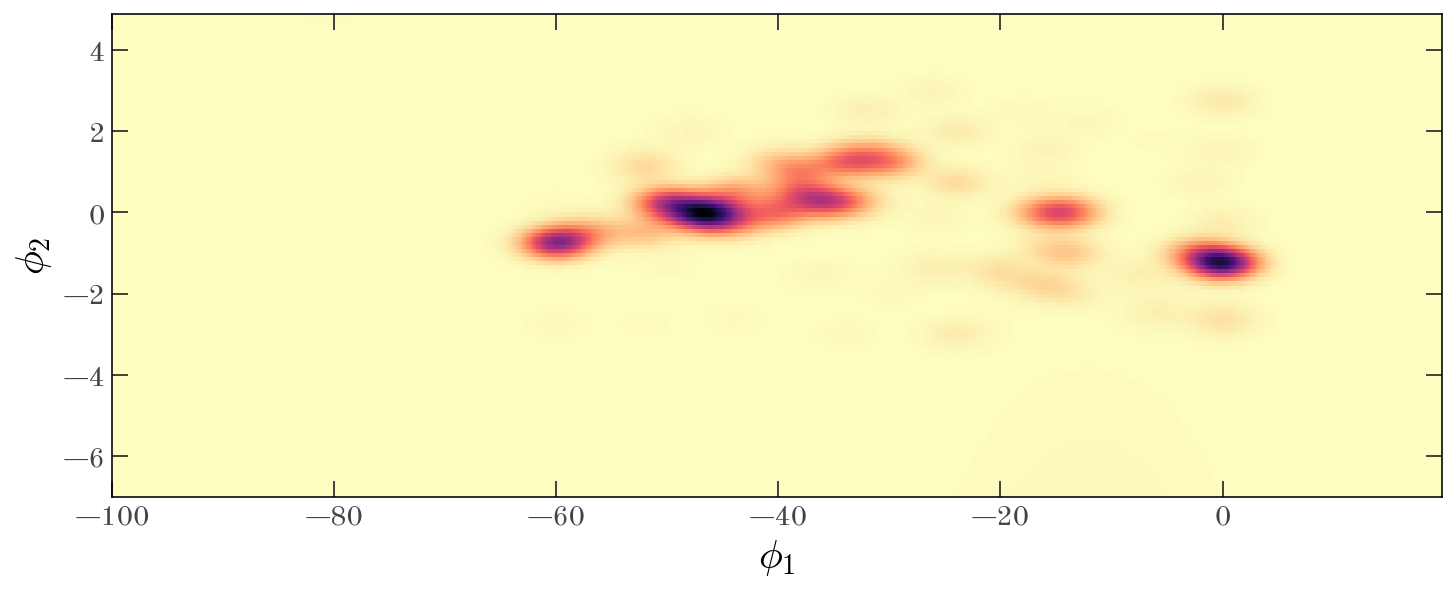

In [31]:
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 720x288 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

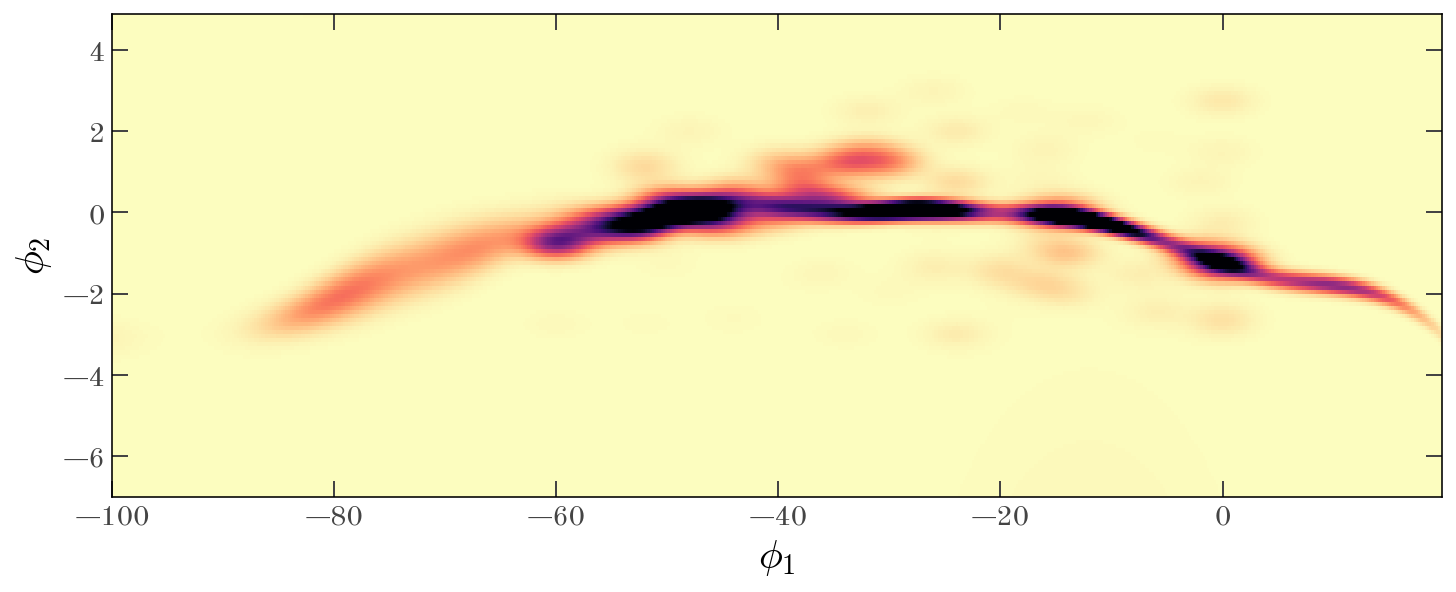

In [32]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 720x288 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

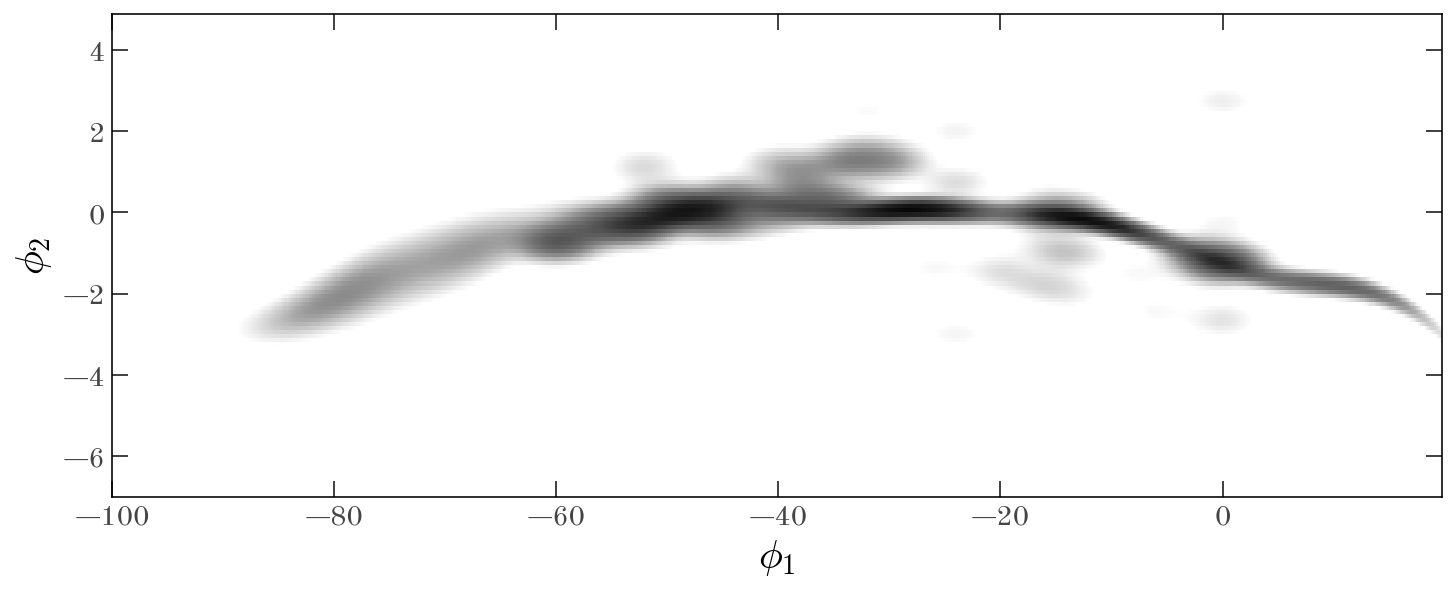

In [33]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

(<Figure size 720x576 with 3 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='$\\mu_{\\phi_1}$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_2}$'>],
       dtype=object))

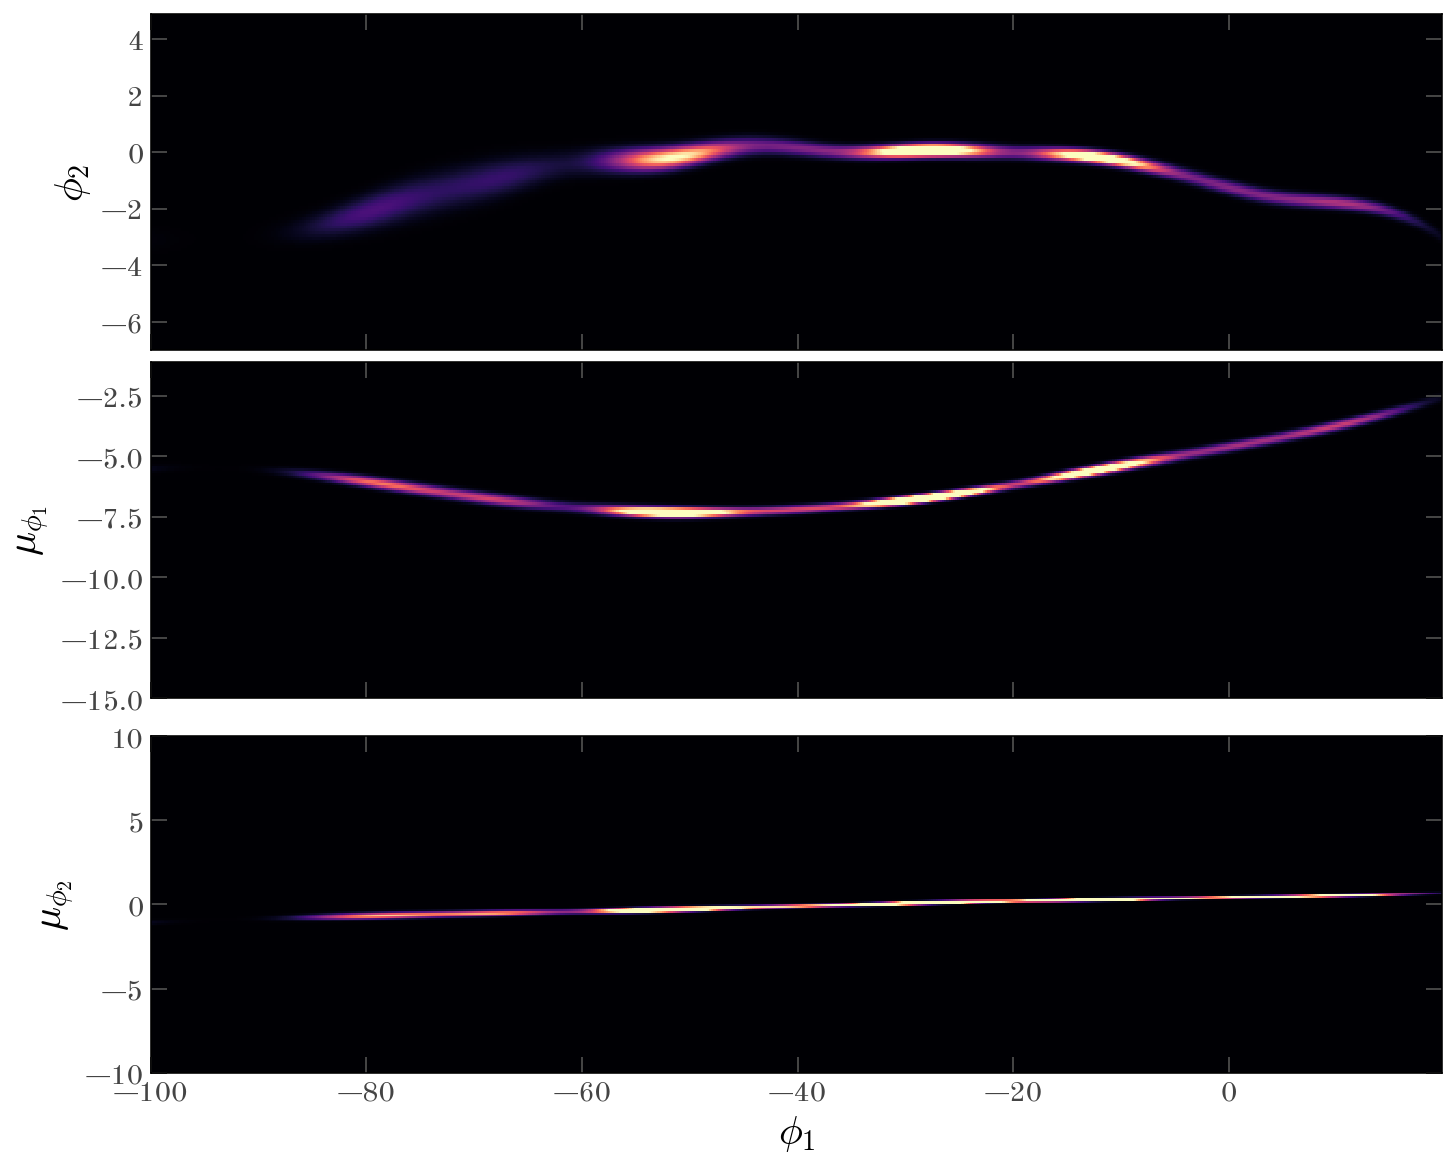

In [34]:
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5))

In [35]:
full_mix_opt_pars['stream']['pm1']

{'ln_std': Array([-2.07241545, -2.04935477, -1.9166361 , -2.05263077, -2.2246677 ,
        -2.31881718, -2.07090533, -2.03197843, -2.05046315], dtype=float64),
 'mean': Array([-5.51715618, -5.76511011, -6.67302389, -7.2767261 , -7.19206328,
        -6.54126551, -5.39109191, -4.20434902, -2.54904711], dtype=float64)}

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

In [36]:
# fig, axes = plt.subplots(
#     len(stream_opt.coord_names) - 1,
#     3,
#     figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
#     sharex=True,
#     sharey="row",
#     constrained_layout=True,
# )

# axes = np.atleast_2d(axes)
# plot_data_projections(
#     data=run_data,
#     grids=GD1Base.default_grids,
#     axes=axes[:, 0],
# )
# full_mix_opt.plot_model_projections(axes=axes[:, 1])
# full_mix_opt.plot_residual_projections(
#     data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
# )

# for ax in axes[-1]:
#     ax.set_xlabel(r"$\phi_1$")

# MCMC:

In [39]:
import blackjax

In [40]:
# This is the main loop that does the sampling for us:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [41]:
def ln_prob(p, data, Components, tied_params=None):
    """
    TODO: keys of inputs have to be normalized to remove tuples
    """
    p = {C.name: C._expand_variable_keys(p[C.name]) for C in Components}

    data = Components[0]._expand_variable_keys(data)
    model = StreamMixtureModel(params=p, Components=Components, tied_params=tied_params)
    return model.ln_likelihood(data) + model.extra_ln_prior(p)

In [71]:
shit = {C.name: C._normalize_variable_keys(full_mix_opt_pars[C.name]) for C in full_Components}

In [74]:
rng_key = jax.random.PRNGKey(42)

fn = jax.tree_util.Partial(
    ln_prob, data=run_data, Components=full_Components, tied_params=tied_params
)
warmup = blackjax.window_adaptation(
    blackjax.nuts,
    fn,
    101,
)
state, kernel, _ = warmup.run(rng_key, shit)

In [ ]:
states = inference_loop(rng_key, kernel, state, 100)

TODO: numpyro sampling broken because of setup_numpyro in StreamMixtureModel

In [37]:
from numpyro.infer import MCMC, NUTS

In [38]:
nuts_kernel = NUTS(StreamMixtureModel.setup_numpyro)

In [ ]:
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, )

>>> rng_key = random.PRNGKey(0)

>>> mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))